In [10]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sqlalchemy
from collections import defaultdict
import importlib
from simulator.ideal import SimulatorIdeal
from simulator.lennard import SimulatorLennard
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, Simulation
from tqdm.notebook import tqdm

import logging.config
import logging
import sys
logging.config.fileConfig("/home/amatevosyan/telegramLogConfig")
logger = logging.getLogger("telegram")

In [2]:
client = Client()

In [3]:
session = client.Session()
print(session.query(sqlalchemy.func.count(Simulation.name), Simulation.group_name).group_by(Simulation.group_name).all())
session.close()

[(2, None), (200, 'Ensemble 1'), (209, 'Ensemble 2')]


In [15]:
sr = L[0][0]

In [17]:
sr.name = "X"

In [19]:
pd.DataFrame(sr)

,X
0.00,10.931408
0.01,10.931433
0.02,10.931474
0.03,10.931531
0.04,10.931603
...,...
499.96,1.791311
499.97,1.791594
499.98,1.791866
499.99,1.792126


In [27]:
# L = {0:[], 1:[], 100:[]}
L =defaultdict(list)
E =defaultdict(list)
with client.Session() as session:
    query = (session.query(Simulation.id, Simulation.Bz, Simulation.name)
             .where(Simulation.group_name=='Ensemble 2')
             .order_by(Simulation.name)).all()[:]

    for id, Bz, name in tqdm(query):
        sim = SimulatorMagnetic(id=id)
        dfs = sim.get_data_frames()
        L[Bz].append(dfs["L"].sum(axis=1))
        L[Bz][-1].name = name

        E[Bz].append((dfs["KE"] + dfs["PE"] + 0.5*dfs["IE"]).sum(axis=1))
        E[Bz][-1].name = name
    
    for key in L.keys():
        df = pd.concat(L[key], axis=1)
        L[key] = df

        df = pd.concat(E[key], axis=1)
        E[key] = df


  0%|          | 0/209 [00:00<?, ?it/s]

In [26]:
L[0]

,1011532992,1305790100,1325792858,139336749
0.00,10.931408,10.948554,10.954215,10.934323
0.01,10.931433,10.948536,10.954200,10.934339
0.02,10.931474,10.948500,10.954176,10.934359
0.03,10.931531,10.948447,10.954144,10.934384
0.04,10.931603,10.948376,10.954105,10.934415
...,...,...,...,...
499.96,1.791311,1.346654,1.882936,1.193458
499.97,1.791594,1.347843,1.883040,1.194166
499.98,1.791866,1.349014,1.883166,1.194850
499.99,1.792126,1.350169,1.883314,1.195510


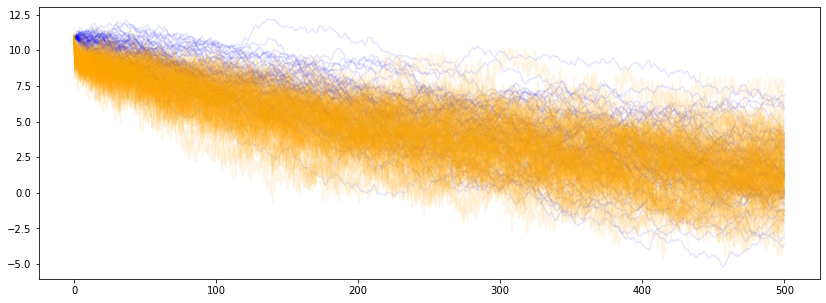

In [31]:
fig = plt.figure(figsize=(14,5))
ax = plt.gca()
L[0].plot(alpha=0.1, color="blue", ax=ax)
L[1].plot(alpha=0.1, color="orange", ax=ax)
# L[100].plot(alpha=0.1, color="red", ax=ax)

ax.get_legend().remove()

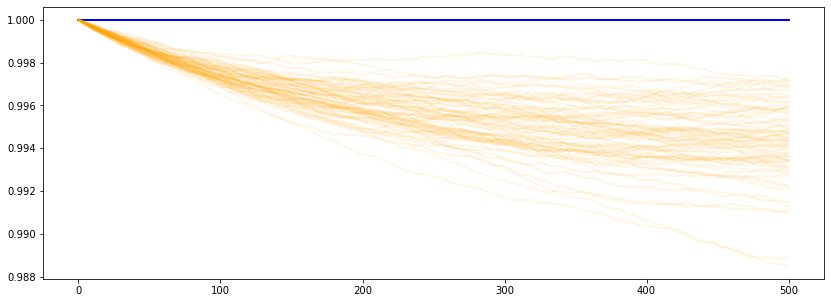

In [45]:
fig = plt.figure(figsize=(14,5))
ax = plt.gca()
(E[0]/E[0].iloc[0]).plot(alpha=0.1, color="blue", ax=ax)
(E[1]/E[1].iloc[0]).plot(alpha=0.1, color="orange", ax=ax)
# (E[100]/E[100].iloc[0]).plot(alpha=0.1, color="orange", ax=ax)

# E[100].plot(alpha=0.1, color="orange", ax=ax)

ax.get_legend().remove()

In [ ]:
simB0 = SimulatorMagnetic()
simB0.load("simB0_anisotrope_push B-0 N-157 rec-20001 07-05-2022 03-46-13.pkl")
simB0_iso = SimulatorMagnetic()
simB0_iso.load("simB0_isotrope_push B-0 N-151 rec-1001 07-01-2022 10-52-07.pkl")
simB1 = SimulatorMagnetic()
simB1.load('simB1_anisotrope_push B-1 N-157 rec-20001 07-05-2022 03-38-36.pkl')
simB1_iso = SimulatorMagnetic()
simB1_iso.load('simB1_isotrope_push B-1 N-151 rec-1001 07-01-2022 10-52-12.pkl')

In [ ]:
dfs = simB0.get_data_frames(record_interval=0.01)
dfs1 = simB1.get_data_frames(record_interval=0.01)

In [ ]:
ax = dfs["L"].sum(axis=1).plot()
dfs["BInertia"].sum(axis=1).plot(ax=ax)
(dfs["L"] + dfs["BInertia"]).sum(axis=1).plot()
plt.title("L conservation");

In [ ]:
rl=5000
plt.figure(figsize=(14,5))
plt.title("z angular momentum")
ax = plt.gca()

rol = dfs["L"].sum(axis=1).rolling(rl)
rol.mean().plot(alpha=1, ax=ax, label="B=0")
plt.fill_between(dfs["L"].index, (rol.mean() + rol.std()), (rol.mean() - rol.std()), color="Blue", alpha=0.3, label="1 std")

rol = dfs1["L"].sum(axis=1).rolling(rl)
rol.mean().plot(alpha=1, ax=ax, label="B=1")
plt.fill_between(dfs["L"].index, (rol.mean() + rol.std()), (rol.mean() - rol.std()), color="Orange", alpha=0.3, label="1 std")

plt.grid()
plt.legend()

In [ ]:
plt.figure(figsize=(14,5))
plt.title("z angular momentum")
ax = dfs["L"].sum(axis=1).plot(alpha=0.5, label="window 0 sec")

rol = dfs["L"].sum(axis=1).rolling(300)
rol.mean().plot(alpha=1, ax=ax, label="window 3 sec")
plt.fill_between(dfs["L"].index, (rol.mean() + rol.std()), (rol.mean() - rol.std()), color="orange", alpha=0.1, label="1 std")


rol = dfs["L"].sum(axis=1).rolling(5000)
rol.mean().plot(alpha=1, ax=ax, label="window 50 sec")
plt.fill_between(dfs["L"].index, (rol.mean() + rol.std()), (rol.mean() - rol.std()), color="green", alpha=0.1, label="1 std")

rol = dfs["L"].sum(axis=1).rolling(10000)
rol.mean().plot(alpha=1, ax=ax, label="window 100 sec")
plt.fill_between(dfs["L"].index, (rol.mean() + rol.std()), (rol.mean() - rol.std()), color="red", alpha=0.1, label="1 std")

# (rol.mean() + rol.std()).plot(alpha=1, ax=ax, label="window 50 sec")
# (rol.mean() - rol.std()).plot(alpha=1, ax=ax, label="window 50 sec")


plt.grid()
plt.legend()
# ax.get_legend().remove()

In [ ]:
plt.figure(figsize=(14,5))
plt.title("Energy (note that x axis is scaled)")
ax = dfs["KE"].sum(axis=1).plot(label="KE")
dfs["PE"].sum(axis=1).plot(ax=ax, label="PE")
dfs["IE"].sum(axis=1).plot(ax=ax, label="IE")
(dfs["KE"] + dfs["PE"] + 0.5*dfs["IE"]).sum(axis=1).plot(label="total")
plt.xlim(-3,30)
plt.legend()
# plt.title("E conservation");

In [ ]:
Ls = dfs["L"].sum(axis=1).loc[100:]
print(Ls.mean(), Ls.std(), len(Ls))

In [ ]:
ax = dfs["L"][range(10)].plot(alpha=0.2)
dfs["L"][range(10)].rolling(100).mean().plot(alpha=1, ax=ax)
ax.get_legend().remove()

In [ ]:
dfs["L"][range(2)].rolling(1).mean().plot()

In [ ]:
ax = dfs["KE"].sum(axis=1).plot()
dfs["PE"].sum(axis=1).plot(ax=ax)
dfs["IE"].sum(axis=1).plot(ax=ax)
(dfs["KE"] + dfs["PE"] + 0.5*dfs["IE"]).sum(axis=1).plot()
plt.title("E conservation");

In [ ]:
dfs["H"] = dfs["KE"] + dfs["PE"] + dfs["IE"]

In [ ]:
plt.hist(dfs["KE"].loc[70:].values.flatten(), bins=100);

In [ ]:
ax = df[df.columns[:20]].plot(alpha=0.1)
df[df.columns[:20]].rolling(1000).mean().plot(ax=ax)
ax.get_legend().remove()